In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
from typing import Tuple
from seaborn import heatmap
from tqdm import tqdm
from scipy.stats import norm
from trading_dp import make_transition_matrix, run_dp

## Pre-process Polymarket data

In [ ]:
# Read in Polymarket data from data folder
data_folder = Path('data')
all_dataframes = []

if os.path.exists("results/polymarket_combined.csv"):
    raise FileExistsError("polymarket_combined.csv already exists")

# Iterate through all market folders
for market_folder in tqdm(sorted(data_folder.glob('market=*')), desc='Processing markets'):
    # Extract market_id from folder name (remove 'market=' prefix)
    market_id = market_folder.name.replace('market=', '')
    
    # Iterate through all CSV files in the market folder
    for csv_file in sorted(market_folder.glob('*.csv')):
        # Extract timestamp from CSV filename (remove .csv extension)
        timestamp = csv_file.stem
        
        # Read the CSV file
        df = pd.read_csv(csv_file)
        
        # Add market_id and timestamp columns
        df['market_id'] = market_id
        df['timestamp'] = timestamp
        
        # Reorder columns to have market_id and timestamp first
        cols = ['market_id', 'timestamp'] + [col for col in df.columns if col not in ['market_id', 'timestamp']]
        df = df[cols]
        
        all_dataframes.append(df)

# Concatenate all dataframes
polymarket_data = pd.concat(all_dataframes, ignore_index=True)

output_file = 'data/polymarket_combined.csv'
polymarket_data.to_csv(output_file, index=False)
print(f"Combined data saved to {output_file}")
print(f"Total rows: {len(polymarket_data)}")
print(f"Total markets: {polymarket_data['market_id'].nunique()}")
print(f"Date range: {polymarket_data['timestamp'].min()} to {polymarket_data['timestamp'].max()}")


FileExistsError: polymarket_combined.csv already exists

In [ ]:
pd.read_csv("data/polymarket_combined.csv").columns

Index(['market_id', 'timestamp', 'date', 'outcome', 'p_open', 'p_high',
       'p_low', 'p_close', 'count', 'odds_close', 'logit_close', 'range_abs',
       'range_rel', 'parkinson_var', 'tr', 'atr_7', 'atr_14', 'atr_30',
       'atr_rel_7', 'atr_rel_14', 'atr_rel_30', 'roll_std_p_7',
       'roll_std_p_14', 'roll_std_p_30', 'roll_std_logit_7',
       'roll_std_logit_14', 'roll_std_logit_30', 'market_sum_close',
       'market_gap_close', 'market_sum_min_native', 'market_sum_max_native',
       'market_gap_maxabs_native', 'market_gap_mean_native', 'trades_count',
       'vol_quote', 'vol_base', 'buy_vol_quote', 'sell_vol_quote',
       'flow_imbalance', 'avg_trade_size_quote', 'median_trade_size_quote',
       'yes_dir_flow_quote', 'yes_dir_flow_base', 'whale_flow_top10p_quote',
       'holders_count', 'supply', 'hhi', 'effective_holders', 'top10_share',
       'top1_share', 'gini', 'avg_balance', 'median_balance'],
      dtype='object')

In [395]:
polymarket_data = pd.read_csv("results/polymarket_combined.csv").sort_values(by=["market_id","timestamp"])
polymarket_data = polymarket_data[polymarket_data["outcome"] == 1]
polymarket_data = polymarket_data[["market_id","timestamp","date","outcome","p_close"]]

polymarket_df = []
for i,d in polymarket_data.groupby("market_id"):
    if not(d.iloc[-1]["p_close"] < 0.90 and d.iloc[-1]["p_close"] > 0.10):  # Filter for closed trades
        d["p_close"] = d["p_close"].apply(lambda x: 1 if x > 0.90 else 0 if x < .10 else x)
        if d["p_close"].sum() < len(d):
            polymarket_df.append(d)

polymarket_df = pd.concat(polymarket_df).sort_values(by=["market_id","timestamp"])
polymarket_df

,market_id,timestamp,date,outcome,p_close
1,0x001dd4fa85859071f1a8006450edd47f834452faf049...,2025-07-20,2025-07-20,1,0.580
3,0x001dd4fa85859071f1a8006450edd47f834452faf049...,2025-07-21,2025-07-21,1,0.610
5,0x001dd4fa85859071f1a8006450edd47f834452faf049...,2025-07-22,2025-07-22,1,0.600
7,0x001dd4fa85859071f1a8006450edd47f834452faf049...,2025-07-23,2025-07-23,1,0.595
9,0x001dd4fa85859071f1a8006450edd47f834452faf049...,2025-07-24,2025-07-24,1,0.630
...,...,...,...,...,...
94463,0xff82765677990d0743ea3a67881892411164432e52e9...,2025-08-16,2025-08-16,1,0.850
94465,0xff82765677990d0743ea3a67881892411164432e52e9...,2025-08-17,2025-08-17,1,1.000
94467,0xff82765677990d0743ea3a67881892411164432e52e9...,2025-08-18,2025-08-18,1,1.000
94469,0xff82765677990d0743ea3a67881892411164432e52e9...,2025-08-19,2025-08-19,1,1.000


<Axes: >

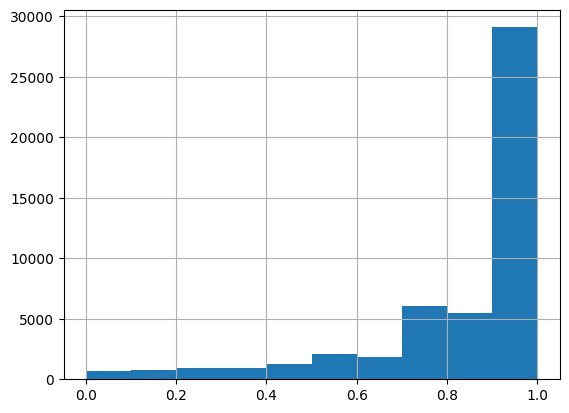

In [398]:
polymarket_data["p_close"].hist()

<Axes: >

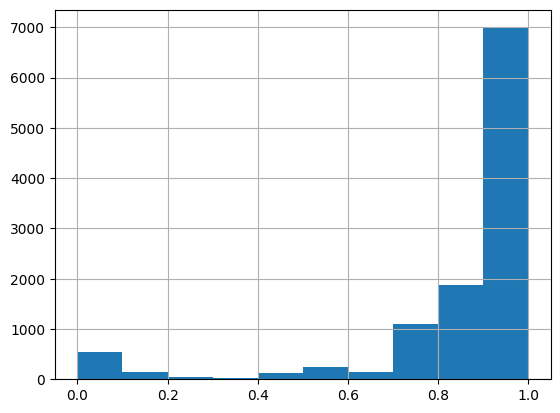

In [396]:
polymarket_df.sort_values(by=["market_id","timestamp"])["p_close"].hist()

In [28]:
polymarket_data["market_id"].iloc[0]

'0x001dd4fa85859071f1a8006450edd47f834452faf0493831291955d5f45eefca'

## Generate Transition Matrices

## Generate DP Tables